# Finding Mean Reversion
## Comparison between PCA and the Johansen Test

In the initial example (["Mean Reversion: How to find it ?](https://drive.google.com/file/d/1a1zFFd4MwZ8ljXtEE16JXyO8W4SWcS4P/view?usp=sharing)) USD 2-5-10 we found that PCA and Johansen gave pretty similar results.

Here I will only make a small change: I'll add the 20yr maturity to the set. 

**Spoiler alert**: the PCA and the Johansen results will be different.

(this notebook has all the code - the next section defines functions required later - keep scrolling)

In [1]:
!pip install johansen
# Request: allow HTTP-post API calls
import requests
# Json: to format as json calls to API
import json 
# Pandas: to plot the timeseries
import pandas as pd
# Datetime: to convert different date formats
import datetime as dt
# Import the Time Series library
import statsmodels.tsa.stattools as ts

from numpy import cumsum, log, polyfit, sqrt, std, subtract

# Useful links
# https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
# https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing-Part-II
# https://www.quantopian.com/posts/pair-trade-with-cointegration-and-mean-reversion-tests
def hurst(ts):
	"""Returns the Hurst Exponent of the time series vector ts"""
	# Create the range of lag values
	lags = range(2, 100)

	# Calculate the array of the variances of the lagged differences
	tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

	# Use a linear fit to estimate the Hurst Exponent
	poly = polyfit(log(lags), log(tau), 1)

	# Return the Hurst exponent from the polyfit output
	return poly[0]*2.0

def MarkovCalibration(df_ts, column_name = None, calType = "MeanReverting"):
    # if no column name is given takes only the first one.
    # to send data to the Azure API we need to:
    # - sort the dates increasing
    # - remove NaNs
    # - put dates in string format readable by Azure
    panda_ts = df_ts.copy()    
    panda_ts.sort_index(inplace = True)
    panda_ts['dates_'] = panda_ts.index
    panda_ts = panda_ts.dropna()

    json_ts['dates'] = panda_ts['dates_'].apply(lambda x: x.strftime('%Y-%m-%d')).tolist()
    if not column_name:
        json_ts['vals'] = panda_ts[panda_ts.columns[0]].tolist()
    else:
        json_ts['vals'] = panda_ts[column_name].tolist()
    json_ts['calType'] = calType
    r = requests.post(url = API_ENDPOINT, json = json_ts)
    r_json = r.json()
    theta = r_json['calibrationResult']['Lambda']
    half_life = -np.log(0.5) * 365.25 / theta
    r_json['calibrationResult']['HalfLife'] = half_life
    sigma = r_json['calibrationResult']['Sigma']
    r_json['calibrationResult']['Std_band'] = np.sqrt(sigma * sigma / (2 * theta))
    return r_json

def adf_critical_value_test(input_ts):
    # returns 1: if the t-stat of the ADF-test is less than the 1% critical value
    # returns 5: if the t-stat of the ADF-test is less than the 5% critical value (but greater than the 1% level)
    # returns 10: if the t-stat of the ADF-test is less than the 10% critical value (but greater than the 1% and 5% levels)
    # return 99: if the t-stat of the ADF-test is greater than the 10% critical value
    adf_test = ts.adfuller(input_ts, 1)
    t_stat = adf_test[0]
    critical_values = adf_test[4]
    if t_stat < critical_values['1%']:
        return int(1)
    if t_stat < critical_values['5%']:
        return int(5)
    if t_stat < critical_values['10%']:
        return int(10)
    return int(99)



# defining the api-endpoint 
API_ENDPOINT = "https://markovsimulator.azurewebsites.net/api/MarkovCalibrator_01?code=UFYL9CcFRERnVbZJ3ELdRRY7u59vD3BgONzaGLNEOekTfKf0Ug9Bfw=="


You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The Johansen test library has to be installed every time - please be patient

(notice that using the interactive notebook you can add more maturities by changing the 'cols' vector just below)

In [0]:

# Treasury rates
QUAND_TS = "https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.json?api_key=o6YKGjyDcseE3LFKrSK3"
# [u'Date', u'1 MO', u'3 MO', u'6 MO', u'1 YR', u'2 YR', u'3 YR', u'5 YR', u'7 YR', u'10 YR', u'20 YR', u'30 YR']
# [  0,       1,       2,       3,       4,       5,       6,       7,       8,       9,        10,       11]
cols = [5, 7, 9, 10]
# correspond to [ 2yr, 5yr, 10yr and 20yr]
# Try adding more maturities (uncomment below):
# cols = [ 2, 3, 5, 8, 9, 10]
# correspond to [3mo, 6mo, 2yr, 7yr, 10yr, 20yr]
# Name of the TimeSeries to be sent to Markov API


The following section of code load data from Quandl.

[u'Date', u'1 MO', u'3 MO', u'6 MO', u'1 YR', u'2 YR', u'3 YR', u'5 YR', u'7 YR', u'10 YR', u'20 YR', u'30 YR']


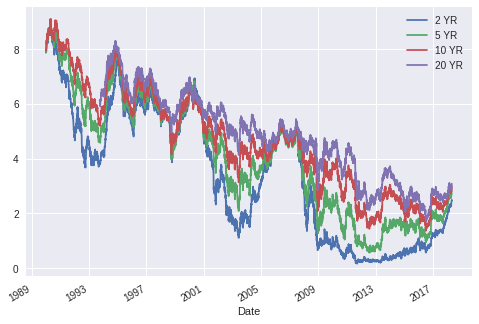

In [3]:
seriesName = 'Condor'
previousTradingDays = 252*10

# Time Series seed
json_ts =  {
   "calType" : "",
    "seriesName" : seriesName,
    "colName" : "Value",
  "dates": [],  
  "vals" : []
}

# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)


# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)

columns_fly = [columns[i] for i in cols]
df_rates[columns_fly].plot()


Lets compute PCA and then check factor by factors whether that could be mean reverting: 

----- factor1 -----
Hurst:  0.5397014661881975
Not Mean Reverting
----- factor2 -----
Hurst:  0.4813513654404485
Not Mean Reverting
----- factor3 -----
Hurst:  0.5028224185375778
Not Mean Reverting
----- factor4 -----
Hurst:  0.37995305992645884
('Mean Reverting at', 1, '%')
('factor4', 'half life', 90.37706106938407)


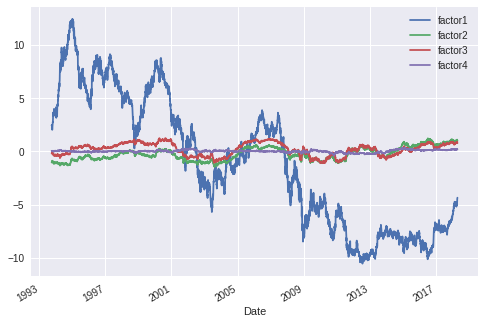

In [4]:


TimeSeries = df_rates[columns_fly]
TS = TimeSeries - TimeSeries.mean()
TScov = TS.cov()

import numpy as np
eig_val_sc, eig_vec_sc = np.linalg.eig(TScov)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

column_names = []
df_ts = TS.copy()

for factor in range(0, len(eig_val_sc)):
    # Eigenvector to analyse
    last_eig = eig_pairs[factor][1]

    # Keep the eigenvalues linked to the column names
    TSeig = pd.DataFrame(last_eig, index = TS.columns)

    Weights = TSeig / (abs(TSeig)).max()

    # Using pandas I can simply multiply the original Timeseries
    # by the Weights,
    column_names.append('factor'+str(factor+1)) 
    df_ts[column_names[factor]] = (TS.dot(Weights)) 
    df_ts = df_ts.dropna()
    column_name = column_names[factor]
    print ("----- "+column_name+" -----")


    print ("Hurst:  %s" % hurst(df_ts[column_name]))
    ad_test = adf_critical_value_test(df_ts[column_name])
    if (ad_test == 99):
        print ("Not Mean Reverting")
    else:
        print ("Mean Reverting at", ad_test,"%")
        r_json = MarkovCalibration(df_ts, column_name = column_name)
        half_life = r_json['calibrationResult']['HalfLife']

        print(column_name, "half life", half_life)
            

df_ts[column_names].plot()



(I expect only the last factor to show mean reversion - if you have changed the number of columns you might get more mean reverting factors).

Let's compare with the Johansen result:

r values are: [0]
----------------------------------
('The', 0, 'th cointegrating relation:')
Johansen Vector
[ 0.02767801 -0.41851962  1.         -0.57369868]
('Johansen vector half life', 53.74265149596533)
PCA Vector
[-0.41755453  1.         -0.63043134  0.00244951]
('PCA vector half life', 90.37751378927585)


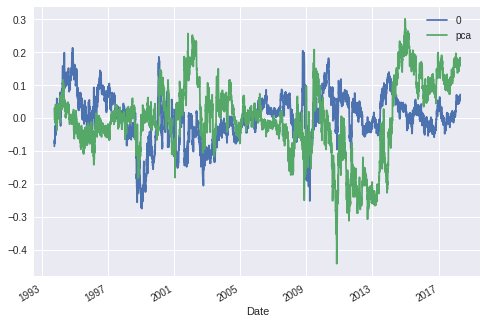

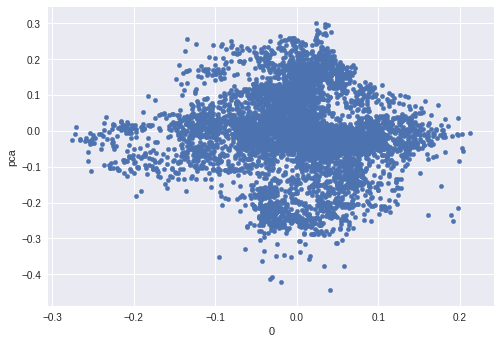

In [5]:

from johansen import Johansen
#
x = TimeSeries.dropna().as_matrix()
x_centered = x - np.mean(x, axis=0)

johansen = Johansen(x_centered, model=2, significance_level=2)
eigenvectors, r = johansen.johansen()

print "r values are: {}".format(r)

eig = [x[1] for x in eig_pairs]

for k in r:
    
    print ("----------------------------------")
    print ("The",k,"th cointegrating relation:")
    
    j_ev = eigenvectors[:, k]/max(abs(eigenvectors[:,k])) 
    pca_ev = eig_pairs[len(eig_pairs)-k-1][1] / max(abs(eig_pairs[len(eig_pairs)-k-1][1])) 
    

    bb = pd.DataFrame(TimeSeries.dot(j_ev))
    r_json = MarkovCalibration(bb)
    half_life = r_json['calibrationResult']['HalfLife']
    mu = r_json['calibrationResult']['Mu']
    cc = bb - mu
    print "Johansen Vector"
    print (j_ev)
    print("Johansen vector half life", half_life)

    
    bb['pca'] = TimeSeries.dot(pca_ev)
    r_json = MarkovCalibration(bb, column_name= 'pca')
    half_life = r_json['calibrationResult']['HalfLife']
    mu = r_json['calibrationResult']['Mu']
    cc['pca'] = bb['pca'] - mu

    print "PCA Vector"
    print (pca_ev)
    print("PCA vector half life", half_life)

    
    cc.plot() 

    cc.plot(x = 0, y = 'pca', kind = 'scatter')



They are different !

(and when showing the scatter plot, they look to be quite uncorrelated - we might even be able to trade them as independent signals)

Ignoring weights less than 10%: 

*   Johansen returns a 5-10-20 fly (roughly with weights 0.42-1-0.57) with a half life of 53 days, while 

*   PCA shows a 2-5-10 fly with (0.42-1-0.53 weights) and a 90 day half life.



Which one to trade ? it will depend on the current level of the strategy - see [Trade Simulator](https://docs.wixstatic.com/ugd/99b304_ac0bd3fd79d44de9bdea773d666baa1f.pdf) for an example of a tool that can analyse both trades, by showing ex-ante Sharpe Ratios derived from known trading horizons and the mean reversion parameters. 

But remember: in Fixed Income whenever you buy a bond the maturity will reduce every day -- holding a 2-5-10 fly for 180 days (twice the half life) would end up giving you a differen trade: a 1.5-4.5-9.5. Practitioners would weight the extra liquidity of a 2-5-10 versus the lower half life of a 5-10-20 (where the 20yr leg might be less liquid).
